[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nithi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


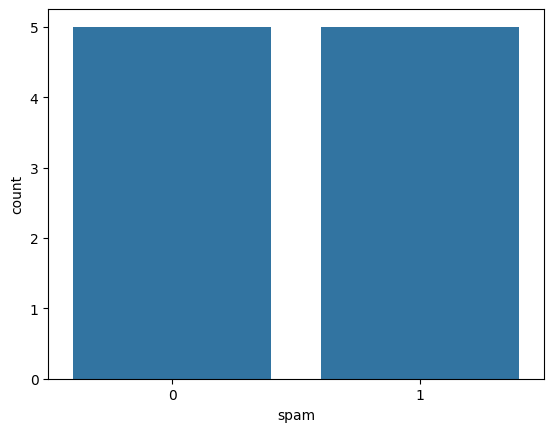

Epoch 1/10


c:\Users\nithi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 

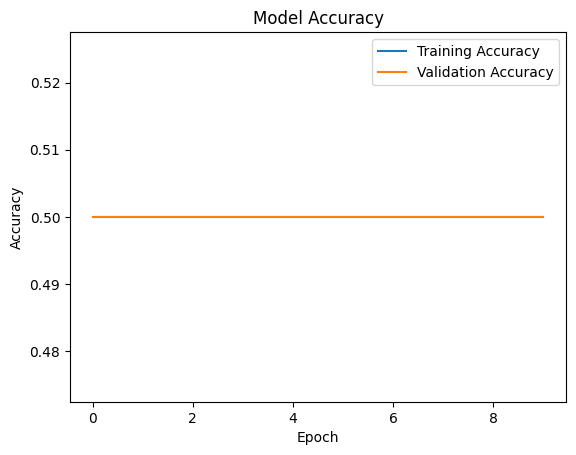

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Prediction: Not Spam


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Dataset
file_path = "Emails.csv"  # Ensure this file is present in the same directory
data = pd.read_csv(file_path)

# Check class balance
sns.countplot(x='spam', data=data)
plt.show()

# **Preprocessing Function**
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply cleaning
data['text'] = data['text'].apply(clean_text)

# **Balancing Dataset**
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]

# Undersampling majority class
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Correct way to combine DataFrames
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['text'], balanced_data['spam'], test_size=0.2, random_state=42)

# **Tokenization & Padding**
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 50
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# **LSTM Model**
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Train Model
history = model.fit(train_padded, y_train, epochs=10, batch_size=32, validation_data=(test_padded, y_test))

# **Plot Accuracy**
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# **Prediction Function**
def predict_email(email_text):
    cleaned_text = clean_text(email_text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded_sequence)[0][0]
    return "Spam" if prediction > 0.5 else "Not Spam"

# Example Usage
email_example = input("Enter your email message: ")
print("Prediction:", predict_email(email_example))

